In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт данных

In [2]:
# Kaggle - сайт, с которого был взят dataframe
df = pd.read_excel('forbes_billionaire.xlsx')

In [3]:
df.head()

,rank,name,net_worth (in billion $),age,country / territory,source,industry
0,1,Bernard Arnault & family,211.0,74.0,France,LVMH,Fashion & Retail
1,2,Elon Musk,180.0,51.0,United States,"Tesla, SpaceX",Automotive
2,3,Jeff Bezos,114.0,59.0,United States,Amazon,Technology
3,4,Larry Ellison,107.0,78.0,United States,Oracle,Technology
4,5,Warren Buffett,106.0,92.0,United States,Berkshire Hathaway,Finance & Investments


__rank__ - Место в рейтинге Forbes

__name__ - Имя

__net_worth (in billion $)__ - чистые доходы

__age__ - Возраст

__country / territory__ - страна/территория

__source__ - источник дохода

__industry__ - индустрия

Задача:
- На основе регрессионного анализа научиться предсказывать примерный доход предпринимателя из рейтинга Forbes по его месту в этом рейтинге и другим характеристикам

Информация о признаках:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   rank                      2655 non-null   int64  
 1   name                      2655 non-null   object 
 2   net_worth (in billion $)  2655 non-null   float64
 3   age                       2588 non-null   float64
 4   country / territory       2655 non-null   object 
 5   source                    2655 non-null   object 
 6   industry                  2655 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 145.3+ KB


Размерность датафрейма:

In [5]:
df.shape

(2655, 7)

# Обработка и первичный анализ:

Диагностика пропусков:

In [6]:
df.isna().sum()

rank                         0
name                         0
net_worth (in billion $)     0
age                         67
country / territory          0
source                       0
industry                     0
dtype: int64

In [7]:
df = df.dropna()

Мы видим пропуски только в переменной "age" и удаляем их

Описательные статистики:

In [8]:
df.describe()

,rank,net_worth (in billion $),age
count,2588.000000,2588.000000,2588.000000
mean,1286.205564,4.660781,65.129444
std,743.610214,9.920845,13.255592
min,1.000000,1.000000,18.000000
25%,636.000000,1.500000,56.000000
50%,1292.000000,2.350000,65.000000
75%,1905.000000,4.300000,75.000000
max,2540.000000,211.000000,101.000000


Описательные статистики для категориальных переменных:

In [9]:
df.describe(include=[object])

,name,country / territory,source,industry
count,2588,2588,2588,2588
unique,2573,77,893,18
top,Scott Smith,United States,Real estate,Finance & Investments
freq,2,739,150,364


Мы видим, что одно имя повторяется в данных два раза, когда так быть не должно. В данных скорее всего есть повторы

In [10]:
df[df['name'] == 'Scott Smith']

,rank,name,net_worth (in billion $),age,country / territory,source,industry
2545,2540,Scott Smith,1.0,73.0,United States,Cloud computing,Technology
2652,2540,Scott Smith,1.0,73.0,United States,Cloud computing,Technology


В данных есть повторы, которые необходимо будет почистить для дальнейшего анализа

In [11]:
df = df.drop_duplicates()

Разделю данные на предикторы и целевой признак

In [12]:
y, X = df['net_worth (in billion $)'], df.drop('net_worth (in billion $)', axis=1)

Приведу всё в числовому типу данных для дальнейшего анализа. Для этого воспользуюсь Label энкодингом

In [13]:
from sklearn.preprocessing import LabelEncoder

cat_vars = set(X.columns) - set(['Age'])
for var in cat_vars:
    X[var] = LabelEncoder().fit_transform(X[var])

X.head()

,rank,name,age,country / territory,source,industry
0,0,215,52,22,445,4
1,1,568,29,73,812,0
2,2,960,37,73,29,16
3,3,1238,56,73,585,16
4,4,2330,70,73,83,5


Масштабирование:

In [14]:
from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(
    StandardScaler().fit_transform(X),
    columns=X.columns,
    index=X.index
)

X.head()

,rank,name,age,country / territory,source,industry
0,-4.920270,-1.442480,0.669226,-0.840585,-0.002269,-0.883916
1,-4.894377,-0.967221,-1.069301,1.149927,1.512282,-1.727614
2,-4.868484,-0.439456,-0.464595,1.149927,-1.719036,1.647176
3,-4.842591,-0.065173,0.971579,1.149927,0.575489,1.647176
4,-4.816697,1.405030,2.029813,1.149927,-1.496187,-0.672992


Удаление выбросов методом трёх стандартных отклонений:

In [15]:
X = X[(np.abs(X) < 3)].dropna()
y = y[X.index]

# Корреляционный анализ

Выведу корреляционную матрицу:

In [16]:
X.corr()

,rank,name,age,country / territory,source,industry
rank,1.000000,0.030997,-0.112227,-0.087304,-0.001979,0.034581
name,0.030997,1.000000,-0.035005,-0.129088,-0.027420,0.002217
age,-0.112227,-0.035005,1.000000,0.165730,-0.045124,-0.145900
country / territory,-0.087304,-0.129088,0.165730,1.000000,0.021214,-0.003906
source,-0.001979,-0.027420,-0.045124,0.021214,1.000000,0.282516
industry,0.034581,0.002217,-0.145900,-0.003906,0.282516,1.000000


Сильных корреляций в данных не наблюдается

Коррелляции целевой переменной:

In [17]:
pd.concat([X, y], axis=1).corr()['net_worth (in billion $)'][:-1]

rank                  -0.996396
name                  -0.030703
age                    0.110922
country / territory    0.082760
source                 0.002298
industry              -0.037332
Name: net_worth (in billion $), dtype: float64

Наблюдаеся сильная зависимость целевой переменной от места в рейтинге, что очевидно

# Тест на нормальное распределение

Для определения нормальности воспользуюсь критерием Шапиро-Улика

Сформулирую гипотезы и установлю уровень значимости:

H0 - данные распределены нормально

H1 - данные нормально не распределены

Уровень значимости alpha = 0.05

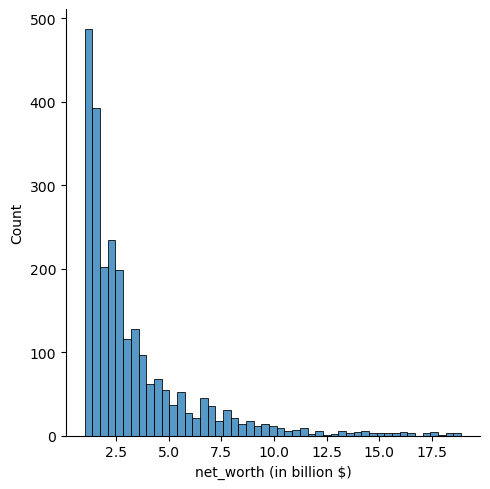

In [18]:
sns.displot(y, kind='hist')

Распределение уже визуально не похоже на нормальное

In [19]:
st.shapiro(y)

ShapiroResult(statistic=0.7337225675582886, pvalue=0.0)

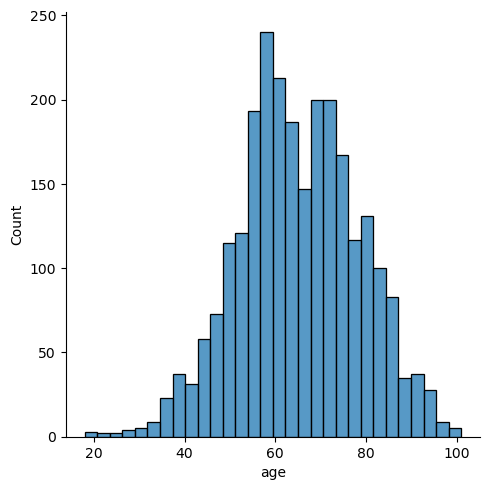

In [20]:
sns.displot(df['age'], kind='hist')

In [21]:
st.shapiro(df['age'])

ShapiroResult(statistic=0.9966691136360168, pvalue=1.931908991537057e-05)

p-value везде сильно ниже 0.05, следовательно

нормально распределённые переменные в данных отсутствуют, 

поэтому параметрические статистические тесты на основе данных делать нельзя

# Линейная регрессия

Деление на тестовую и тренировочную выборки

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Классическая линейная регрессия

In [23]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train) # Обучу модель линейной регрессии

LinearRegression()

In [24]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = lr.predict(X_test) # Запишу предсказания

mae = mean_absolute_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred)

print(mae, r2)

0.11846781212923309 0.9955541816327262


Свободный член:

In [25]:
lr.intercept_

3.8885248309604643

Оценки коэффициентов линейной регрессии:

In [26]:
pd.DataFrame(
    lr.coef_,
    index=lr.feature_names_in_
)

,0
rank,-4.151092
name,-0.002054
age,0.001968
country / territory,-0.013133
source,0.003099
industry,-0.013684


На основе них делаем вывод, что один признак на целевой влияет очень сильно, когда как остальные - слабо

Построю Residual Plot

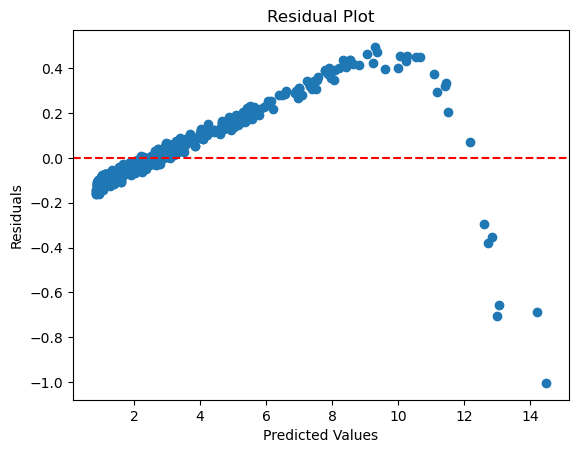

In [27]:
resid = y_pred - y_test # Остатки регрессии

plt.scatter(y_pred, resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Мы видим, что есть выраженная нелинейная зависимость между ошибками и предсказанной переменной.

Регрессия с регуляризацией:

Модель Elastic Net является комбинацией двух типов регуляризации: L1 (Lasso) и L2 (Ridge). Она используется в линейной регрессии для предотвращения переобучения и для обработки ситуаций, когда у вас есть коррелирующие признаки. В Elastic Net есть два ключевых гиперпараметра, которые обычно подбираются численными методами

In [28]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV # Функция для подбора гиперпараметров

en = GridSearchCV(
    estimator=Lasso(),
    param_grid={
        'alpha': np.linspace(0.000001, 10, 100)
    },
    cv=10 # Количество фолдов кросс-валидации
)

en.fit(X_train, y_train) # Обучение модели

en.best_params_ # Вывод подобранных параметров

{'alpha': 1e-06}

Лучшей моделью является модель с наименьшим гиперпараметром alpha

Так как у нас один регрессор имеет очень сильный вес, и, подразумевается, что он сильно важнее остальных, так как мультиколлинеарности нет, для данного случая наилучшая регрессия будет регрессией без регуляризации, так как она будет штрафовать вес самого лучшего предиктора. 

Мы знаем, что в классической модели есть нелинейная зависимость между ошибками и предсказанной переменной. Предположим, что зависимость описывается не линейно. Для такого случая воспользуюсь полиномиальной регрессией

# Полиномиальная регрессия

Создам полиномиальные признаки:

In [29]:
from sklearn.preprocessing import PolynomialFeatures

poly_train = PolynomialFeatures(3, include_bias=False).fit(X_train)
poly_test = PolynomialFeatures(3, include_bias=False).fit(X_test)

X_train_poly = pd.DataFrame(
    poly_train.transform(X_train),
    index=X_train.index,
    columns=poly_train.get_feature_names_out()
)
X_test_poly = pd.DataFrame(
    poly_test.transform(X_test),
    index=X_test.index,
    columns=poly_test.get_feature_names_out()
)

In [30]:
X_train_poly.head()

,rank,name,age,country / territory,source,industry,rank^2,rank name,rank age,rank country / territory,...,country / territory^3,country / territory^2 source,country / territory^2 industry,country / territory source^2,country / territory source industry,country / territory industry^2,source^3,source^2 industry,source industry^2,industry^3
1937,0.594980,1.632562,1.047167,-0.411259,-1.578724,-1.305765,0.354002,0.971342,0.623044,-0.244691,...,-0.069558,-0.267016,-0.220849,-1.025008,-0.847786,-0.701205,-3.934761,-3.254447,-2.691759,-2.226358
2364,0.672660,1.635255,-0.389007,-1.191852,-0.906048,-1.305765,0.452471,1.099970,-0.261670,-0.801711,...,-1.693038,-1.287051,-1.854853,-0.978419,-1.410063,-2.032134,-0.743796,-1.071933,-1.544832,-2.226358
1780,0.543194,0.519138,-2.656651,1.149927,1.751639,1.647176,0.295060,0.281993,-1.443077,0.624633,...,1.520586,2.316249,2.178114,3.528252,3.317836,3.119968,5.374449,5.053930,4.752526,4.469097
2172,0.646767,-1.204177,0.064521,-0.762526,0.142170,-0.462068,0.418307,-0.778822,0.041730,-0.493176,...,-0.443367,0.082664,-0.268667,-0.015412,0.050092,-0.162804,0.002874,-0.009339,0.030354,-0.098654
2558,0.724446,-1.524606,-2.203122,-1.269911,-0.394320,1.647176,0.524823,-1.104495,-1.596044,-0.919982,...,-2.047952,-0.635909,2.656357,-0.197456,0.824824,-3.445507,-0.061312,0.256116,-1.069863,4.469097


Мы видим, что появились квадраты, кубы, и все возможные произведения признаков. Теперь используем эти данные для построения линейной регрессии

Теперь обучу полиномиальную линейную регрессию:

In [31]:
lr.fit(X_train_poly, y_train)

y_pred_poly = lr.predict(X_test_poly)

In [32]:
mae = mean_absolute_error(y_test, y_pred_poly) 
r2 = r2_score(y_test, y_pred_poly)

print(mae, r2)

0.026926415143379505 0.9996606626147779


Видим, что метрики качества модели улучшились

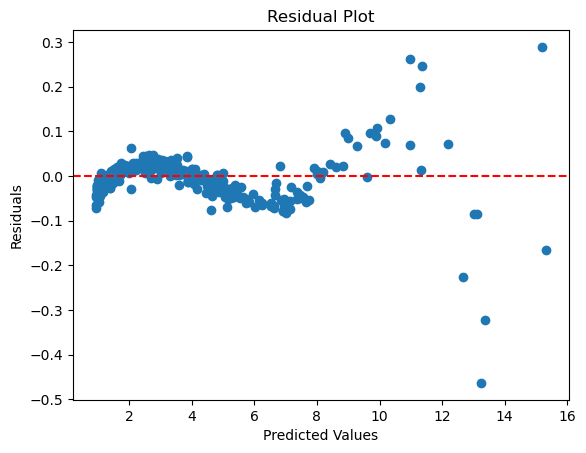

In [33]:
resid_poly = y_pred_poly - y_test # Остатки регрессии

plt.scatter(y_pred_poly, resid_poly)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

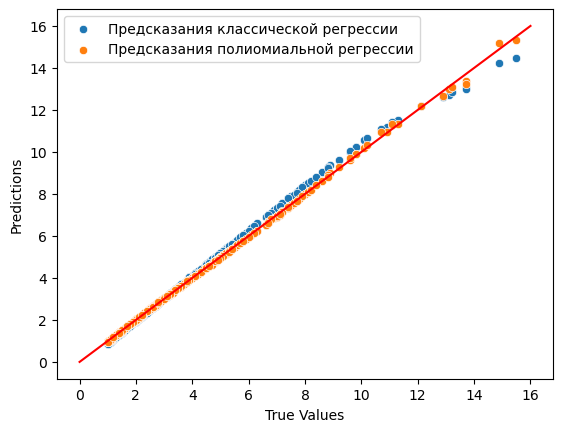

In [34]:
sns.scatterplot(x=y_test, y=y_pred, label='Предсказания классической регрессии')
sns.scatterplot(x=y_test, y=y_pred_poly, label='Предсказания полиомиальной регрессии')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([0, 16], [0, 16], color='red')  # Диагональная линия

Видно, что точки предсказаний полиномиальной регрессии ближе к красной линии, следовательно полиномиальная регрессия лучше и в модели правда есть нелинейная зависимость.

# Логистическая регрессия

Задача:
- Определить к индустрии "Finance & Investments" или "Manufacturing" относится бизнесмен

In [35]:
df_classification = df[
    (df['industry'] == 'Finance & Investments') \
          | (df['industry'] == 'Manufacturing')]

In [36]:
df_classification = df_classification.reset_index(drop=True) # Для удобства обновлю индексы

In [37]:
df_classification.head()

,rank,name,net_worth (in billion $),age,country / territory,source,industry
0,5,Warren Buffett,106.0,92.0,United States,Berkshire Hathaway,Finance & Investments
1,35,Ken Griffin,35.0,54.0,United States,Hedge funds,Finance & Investments
2,46,Reinhold Wuerth & family,29.7,87.0,Germany,Fasteners,Manufacturing
3,48,Jeff Yass,28.5,64.0,United States,"Trading, investments",Finance & Investments
4,49,Jim Simons,28.1,84.0,United States,Hedge funds,Finance & Investments


Выполню всю предварительную обработку

In [38]:
# Разделю предикторы и целевую переменную
y, X = df_classification['industry'], df_classification.drop('industry', axis=1)

# Кодирую категориальные признаки
cat_vars = set(X.columns) - set(['Age', 'net_worth (in billion $)'])
for var in cat_vars:
    X[var] = LabelEncoder().fit_transform(X[var])

# Стандартизация
X = pd.DataFrame(
    StandardScaler().fit_transform(X),
    columns=X.columns,
    index=X.index
)

# Удалю выбросы
X = X[(np.abs(X) < 3)].dropna()
y = y[X.index]

# Так как переменные ранга и дохода создают мультиколлинеарность, удалю одну из них:
X = X.drop('rank', axis=1)

# Разделю на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Создаю модель логистической регрессии

In [39]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train) # Обучаю модель

y_pred = lr.predict(X_test) # Получаю предсказания

Оценю модель:

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_test, y_pred)

array([[58, 17],
       [14, 45]], dtype=int64)

In [41]:
accuracy_score(y_test, y_pred)

0.7686567164179104

Из матрицы ошибок мы видим, что значения False Positive и False Negative имеют близкие значения, значит для адекватной оценки модели достаточно только accuracy_score. Исходя из этой метрики, наша модель будет давать верный ответ в 77% случаев 

# Кластеризация

Формулировка задачи:
- Запланирован выпуск трёх журналов, посвящённых людям из списка Forbes. Нужно определить, контент про каких людей в какой журнал войдёт.

Подготовка данных:

In [42]:
df_cluster = df.copy()

# Кодирую категориальные признаки
cat_vars = set(df_cluster.columns) - set(['Age', 'net_worth (in billion $)'])
for var in cat_vars:
    df_cluster[var] = LabelEncoder().fit_transform(df_cluster[var])

# Стандартизация
df_cluster = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster),
    columns=df_cluster.columns,
    index=df_cluster.index
)

In [43]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=3, n_init=100)

k_means.fit(df_cluster) # Обучаю модель

KMeans(n_clusters=3, n_init=100)

Добавлю признак с кластерами к исходному датасету

In [44]:
df = pd.concat(
    [df, pd.Series(k_means.labels_, index=df.index, name='clusters')], 
    axis=1
)

In [45]:
df['clusters'].value_counts()

1    1322
0    1127
2     126
Name: clusters, dtype: int64

Мы видим, что в кластере 2 людей сильно меньше, чем в остальных кластерах

<Axes: xlabel='net_worth (in billion $)', ylabel='age'>

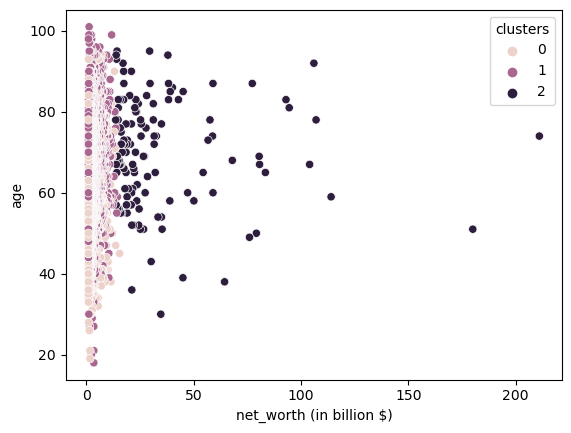

In [46]:
sns.scatterplot(data=df, x='net_worth (in billion $)', y='age', hue='clusters')

Как мы видим на диаграмме, во второй кластер попали люди с самым высоким доходом, когда как в 1 и 2 кластере разделение произошло независимо от дохода 

<Axes: xlabel='clusters', ylabel='proportion'>

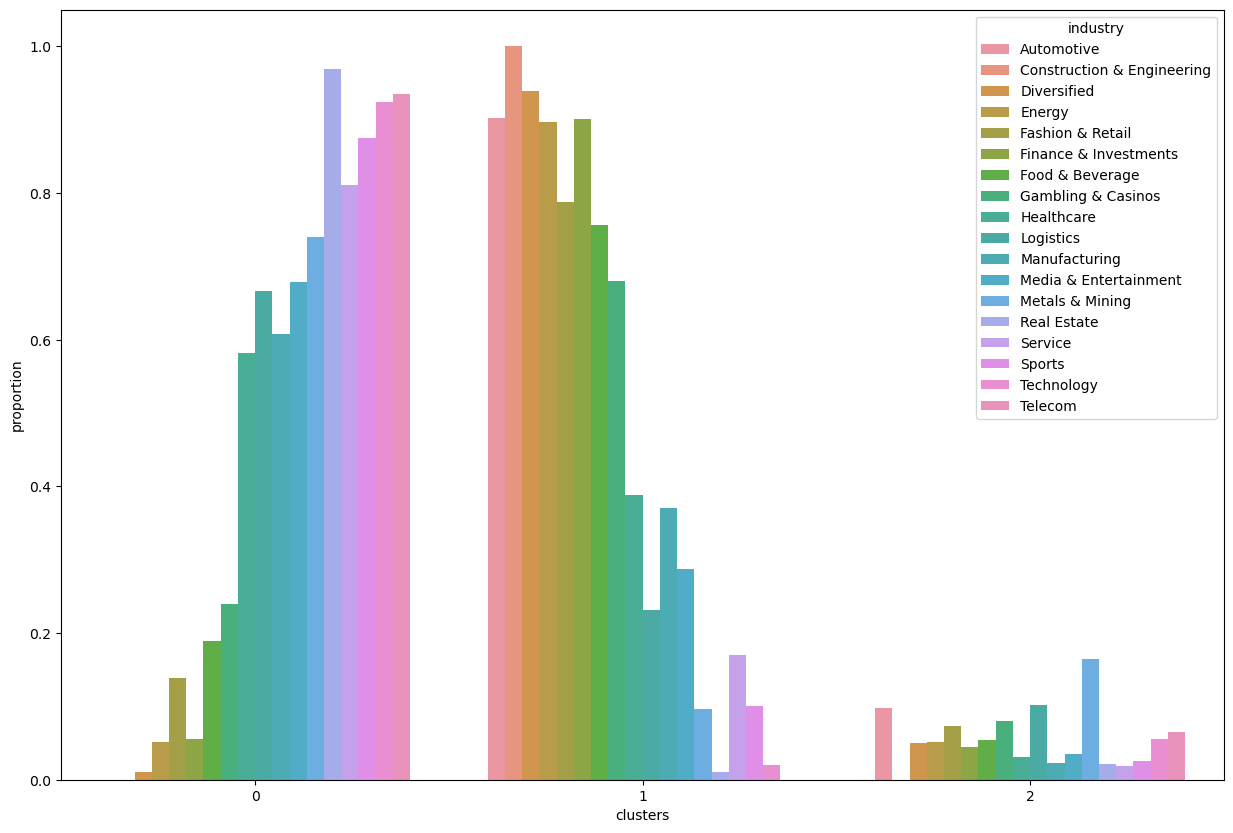

In [47]:
df_industry_group = df.groupby('industry', as_index=False)['clusters'].\
    value_counts(normalize=True).\
    sort_values(by='industry')

plt.figure(figsize=(15, 10))
sns.barplot(data=df_industry_group, x='clusters', y='proportion', hue='industry')

На данной диаграмме видно, сколько в процентах от каждой индустрии наблюдений попало в каждый кластер. Мы видим, что в нулевой и первый кластер попали преимущественно наблюдения из разных индустрий